# 重叠分区

In [1]:
from testing import viz_expr # 可视化 relay

In [2]:
import tvm
from tvm import relay
from tvm.relay.dataflow_pattern import *

In [3]:
x = relay.var("x")
var = relay.var("var")
mean = relay.var("mean")
beta = relay.var("beta")
gamma = relay.var("gamma")
BN = relay.op.nn.batch_norm(x, gamma, beta, mean, var, epsilon=1e-5)
T1 = BN[0]
T2 = BN[0]
add = T1 + T2

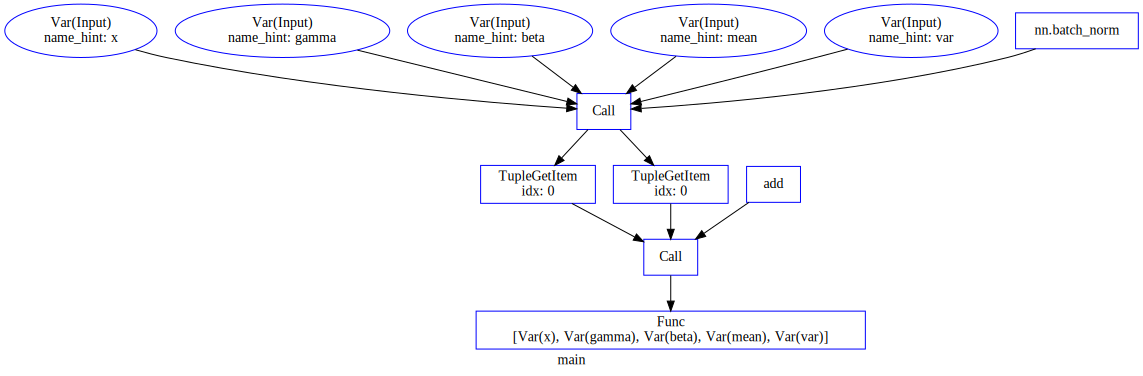

In [4]:
viz_expr(add)

In [5]:
print(tvm.IRModule.from_expr(add))

def @main(%x, %gamma, %beta, %mean, %var) {
  %0 = nn.batch_norm(%x, %gamma, %beta, %mean, %var);
  %1 = %0.0;
  %2 = %0.0;
  add(%1, %2)
}



构建模式：

In [6]:
x = wildcard()
gamma = wildcard()
beta = wildcard()
moving_mean = wildcard()
moving_var = wildcard()
bn_node = is_op("nn.batch_norm")(x, gamma, beta, moving_mean, moving_var)
tuple_get_item_node = TupleGetItemPattern(bn_node, 0)

分割计算图：

In [7]:
partitioned = tuple_get_item_node.partition(add)

In [8]:
assert partitioned == add

另外一个例子：

In [9]:
pattern = is_op("nn.relu")(is_op("nn.conv2d")(wildcard(), wildcard()))

x = relay.var("input")
w = relay.var("weight")
conv2d = relay.op.nn.conv2d(x, w)
relu = relay.op.nn.relu(conv2d)
out = relu + conv2d

assert pattern.partition(out) == out